# Introducción

[Clutch](https://clutch.co/) es un sitio B2B[^1] de calificaciones y reseñas de empresas tecnológicas. Aquí, éstas son evaluadas en función de una serie de factores cuantitativos y cualitativos entre las que se encuentran reseñas certificadas que realizan sus cliente. Permite constituir una reputación a través de revisiones verificadas de terceros.

No solo es relevante como punto de consulta de información valiosa para la ponderación de proveedores; sino también, como se pretende en el presente, hacer un análisis de la presencia de la competencia en el mercado para establecer puntos de comparación.

[^1]: Negocio a negocio (del inglés business-to-business o B2B)

# Objetivo

Con este desarrollo se aspira a extraer referencias allí expuesta para constituir una radiografía del mercado. La intensión es simplificar la información en un cuadrante de posicionamiento que permita una rápida comparativa de las empresas que operan en un mismo área (delimitada por rubro y geografía).

La principales técnicas a utilizar son: Web Scraping para recopilar información de forma automática expuesta en Internet, y Text Mining para preprocesar los datos no estructurados obtenidos del portal citado.

# Alcance

El entregable que resulta de este trabajo supone:

- Una pieza de código automatizable que extraiga el texto tal como se expone en el sitio web.
- Preprocesamiento de los registros utilizando técnicas de Text Mining para obtener un set de datos estructurados.
- Reconocer las entidades relevantes de cada lectura para disponer el resultado en forma adecuada para la construcción el resumen pretendido. 

# Consideraciones (a completar)

describir los aspectos a tener en cuenta cuando se hace scraping: CAPTCHA, contenido dinámico, etc.

# Resto de tareas (a completar) 

Cron en hosting
Monitoreo: agente externo para ver si anda -> si anda, me autochequeo
Resolver la caida de internet -> por ejemplo, reintentando
Resolver errores html (40, 50)
Chequear que la estructura cambio o no
Describir cómo construir el dashboard sin construir nada
...

# Futuras lineas de trabajo (a completar)

Extender el origen de información a otros sitios que brinde un servicio de idénticas características.

# Desarrollo

In [1]:
import requests
import pandas as pd

from re import sub
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from typing import Iterable, Union

pd.set_option('display.max_columns', None)

## Categorías

In [2]:
categories = ['app-developers', 'web-developers', 'developers']

## Utilidades

In [3]:
def get_search_page(category: str, page_number: int) -> BeautifulSoup:
  clutch_argentina = requests.get(f'https://clutch.co/ar/{category}?page={page_number}')
  return BeautifulSoup(clutch_argentina.text)

def get_company_profile(profile_link: str) -> BeautifulSoup:
  profile = requests.get(f'https://clutch.co/{profile_link}')
  return BeautifulSoup(profile.text)

def is_last_page(beautiful_soup_page: BeautifulSoup) -> bool:
  return not beautiful_soup_page.select('li.page-item.last > a')

def get_element_text_if_exists(elements: Iterable) -> Union[str, None]:
  if elements is not None and len(elements) > 0:
    return elements[0].text.strip()

def snake_case(value: str) -> str:
  return '_'.join(sub('[^0-9a-zA-Z\s\_]+', '', value).split()).lower()

In [4]:
def create_row(provider_li: BeautifulSoup) -> dict:
    row = {}
    
    company_info = provider_li.select('h3.company_info a')
    row['company_name'] = get_element_text_if_exists(company_info)
    row['rating'] = get_element_text_if_exists(provider_li.select('.rating'))
    row['reviews'] = get_element_text_if_exists(provider_li.select('.reviews-link'))

    #Min. project size, Avg. hourly rate, Employees, Location
    items = provider_li.select('.module-list > div')
    for item in items:
      key_name = BeautifulSoup(item.attrs['data-content']).text
      row[key_name] = get_element_text_if_exists(item.select('span'))

    #Service Focus
    percentages = provider_li.select('.chartAreaContainer > div')
    for percentage in percentages:
      content = BeautifulSoup(percentage.attrs['data-content'])
      row[f'service_focus_{content.b.text}'] = content.i.text

    #Client focus
    profile_link = provider_li.select('li.website-profile > a')[0].attrs['href']
    profile = get_company_profile(profile_link)
    client_focus = profile.find("div", string='Client focus')

    if client_focus:
      for client in client_focus.find_next_sibling().select('div.grid.custom_popover'):
        key_name = BeautifulSoup(client.attrs['data-content']).b.text
        row[f'client_focus_{key_name}'] = client.text
      
    return row

In [5]:
search_page = get_search_page('developers', 0)
search_page

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1.0, minimum-scale=1.0, maximum-scale=2.0" name="viewport"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type">
<title>Top Software Developers in Argentina - 2022 Reviews | Clutch.co</title>
<meta content="Detailed client reviews of the leading Argentina software developers. Hire the best custom software development company in Argentina." name="description"/>
<meta content="on" http-equiv="x-dns-prefetch-control"/>
<link href="/static/icons/favicon-white.png" rel="shortcut icon" type="image/png"/>
<link href="/static/icons/apple-touch-icon120x120.png" rel="apple-touch-icon" sizes="120x120" type="application/octet-stream"/>
<link href="/static/icons/apple-touch-icon152x152.png" rel="apple-touch-icon" sizes="152x152" type="application/octet-stream"/>
<link href="/static/icons/apple-touch-icon167x167.png" rel="apple-touch-icon" sizes="167x167" type="applicatio

In [6]:
test_row = create_row(search_page.select('ul.directory-list li.provider-row')[0])
test_row

{'company_name': 'BEON Tech Studio',
 'rating': '4.9',
 'reviews': '27 reviews',
 'Min. project size': '$50,000+',
 'Avg. hourly rate': '$25 - $49 / hr',
 'Employees': '50 - 249',
 'Location': 'Buenos Aires, Argentina',
 'service_focus_Custom Software Development': '50%',
 'service_focus_IT Staff Augmentation': '50%',
 'client_focus_Midmarket ($10M - $1B)': '50%',
 'client_focus_Small Business (<$10M)': '50%'}

## Scraping

In [7]:
def get_companies(category: str) -> pd.DataFrame:
  page_number = 0
  rows = []

  with tqdm() as pbar:
    pbar.set_description(f"Categoria: {category}")

    while True:
      pbar.update(1)

      page = get_search_page(category, page_number)
      company_list = page.select('ul.directory-list li.provider-row')
      rows += [create_row(company) for company in company_list]
      page_number += 1

      if is_last_page(page):
        break
    
  return pd.DataFrame(rows)

In [8]:
# borrar, es para que tarde menos la prueba
categories = ['app-developers']

companies = []
for category in categories:
    companies = get_companies(category)

companies = pd.concat(companies)
companies.head()

0it [00:00, ?it/s]

### Nombre de columnas

In [ ]:
companies.columns = map(snake_case, companies.columns)
companies.head()

In [ ]:
# test
# print(get_companies('web-developers').shape)
# print(BeautifulSoup(requests.get(f'https://clutch.co/ar/web-developers').text).select('.tabs-info')[0].text)

# print(get_companies('app-developers').shape)
# print(BeautifulSoup(requests.get(f'https://clutch.co/ar/app-developers').text).select('.tabs-info')[0].text)

# print(get_companies('developers').shape)
# print(BeautifulSoup(requests.get(f'https://clutch.co/ar/developers').text).select('.tabs-info')[0].text)

### Algunos Datos

In [ ]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business,service_focus_artificial_intelligence,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_iot_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_other,service_focus_other_application_development,service_focus_content_marketing,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_web_design,service_focus_it_managed_services,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_product_design,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_branding,service_focus_email_marketing,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Campo Salles, Argentina",40%,30%,30%,80%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25%,10%,40%,40%,25%,35%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flux IT,4.9,10 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30%,40%,30%,50%,25%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Simplex Software,4.7,10 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"CMK, Argentina",25%,10%,15%,50%,NaN,50%,NaN,40%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20%,30%,10%,70%,NaN,30%,NaN,30%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preproceso

### Duplicados

In [ ]:
companies = companies.drop_duplicates()

NameError: name 'companies' is not defined

### Valores N/A

In [ ]:
companies = companies.fillna('0')

NameError: name 'companies' is not defined

## En clase

In [ ]:
clutch_argentina = requests.get(f'https://clutch.co/ar/developers?page=0')
bs_clutch = BeautifulSoup(clutch_argentina.text)

ultima_pagina = bs_clutch.select('li.page-item.last > a')[0].attrs['data-page']

current_page = bs_clutch.select('li.page-item.active > a')[0].attrs['data-page']

print(ultima_pagina, current_page)

6 0


In [ ]:
def get_element_if_exists(elements):
  if len(elements) > 0:
    return elements[0].text.strip()

In [ ]:
empresas = []

for page_number in range(int(ultima_pagina) + 1):
  clutch_argentina = requests.get(f'https://clutch.co/ar/developers?page={page_number}')
  bs_clutch = BeautifulSoup(clutch_argentina.text)  
  li = bs_clutch.select('ul.directory-list li.provider-row')

  for l in li:
    d = {}
    d['nombre'] = get_element_if_exists(l.select('h3.company_info a'))
    d['rating'] = get_element_if_exists(l.select('.rating'))
    d['reviews'] = get_element_if_exists(l.select('.reviews-link'))

    items = l.select('.module-list > div')
    for i in items:
      key_name = BeautifulSoup(i.attrs['data-content']).text
      d[key_name] = get_element_if_exists(i.select('span'))

    perc = l.select('.chartAreaContainer > div')
    for p in perc:
      contenido = BeautifulSoup(p.attrs['data-content'])
      d[contenido.b.text] = contenido.i.text
      
    empresas.append(d)

In [ ]:
resultado = pd.DataFrame(empresas)
resultado.shape

(328, 64)

In [ ]:
resultado.head()

,nombre,rating,reviews,Min. project size,Avg. hourly rate,Employees,Location,Custom Software Development,IT Staff Augmentation,Mobile App Development,...,Logo,Video Production,Pay Per Click,Customs brokerage,Other Design,Advertising,"Commercial Financing, Funding, & Investment",Translation,Other Digital Marketing,Unified Communications Consulting & SI
0,BEON Tech Studio,4.9,26.0,"$50,000+",$25 - $49 / hr,50 - 249,"Buenos Aires, Argentina",50%,50%,0,...,0,0,0,0,0,0,0,0,0,0
1,Clarika,4.8,13.0,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",30%,30%,20%,...,0,0,0,0,0,0,0,0,0,0
2,Crombie,4.8,15.0,"$10,000+",$25 - $49 / hr,10 - 49,"FQC, Argentina",25%,25%,20%,...,0,0,0,0,0,0,0,0,0,0
3,Patagonian,4.9,6.0,"$75,000+",$50 - $99 / hr,50 - 249,"General Roca, Argentina",20%,0,20%,...,0,0,0,0,0,0,0,0,0,0
4,Rootstrap,4.8,34.0,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",10%,0,25%,...,0,0,0,0,0,0,0,0,0,0


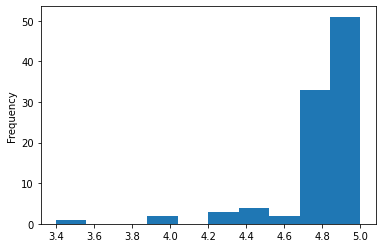

In [ ]:
resultado.rating.astype(float).plot.hist()

In [ ]:
resultado = resultado.fillna('0')
resultado.reviews = resultado.reviews.str.split(' ').str[0]
resultado.reviews = resultado.reviews.astype(float)
resultado.rating = resultado.rating.astype(float)

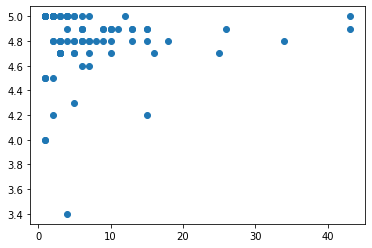

In [ ]:
empresas_con_rating = resultado.query('reviews != 0')
plt.scatter(empresas_con_rating.reviews, empresas_con_rating.rating)

-agregar las categorias: web, software dev(ya esta), mobiel
- eliminar duplicados
- elegir una empresa
- sacar client focus
- filtrar aquellas empresas que al menos dos principales (de mayor porcentaje) de las caracteristicas.
- armar métrica de diferencia: cantidad de empleados maximo y restar la elegida, lo mismo con min project size, mismo tarifa. ¿armamos una sola metrica con las tres o las tres por separadas?
- 
- graficar